Note: I created a new MC python file called MCForecastTools_3Mod.py. It is literally the same as MCForecastTools_2Mod.py but the only difference is that I commented out the printing step part so it won't keep printing out "Running Monte Carlo simulation number {n}" every time. Now, there is no visual cue when the code is done running but at least the output isn't overflowed with the print line. The way I know when the cell is finished running is when the cell number on the left is an asterik [*], meaning that it is still running. After it becomes a numbered cell, it means the code has finished running.

In [1]:
# Import the required libraries and dependencies
import os
from pathlib import Path
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools_3Mod import MCSimulation

%matplotlib inline

In [30]:
import numpy as np
import datetime

import matplotlib.pyplot as plt
# from scipy.stats import norm
# import statistics

In [3]:
load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [6]:
type(alpaca_api_key)
type(alpaca_secret_key)

str

In [40]:
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

tickers = ["MSFT"]
timeframe = "1D"


now = datetime.datetime.now()
current_time = now.strftime("%H:%M")
current_time = int(str(current_time[0:2] + current_time[3:5]))
yesterday = datetime.date.today() - datetime.timedelta(days = 1)

# print(str(current_time[0:2] + current_time[3:5]))
# print(current_time)
if current_time < 930:
    start_date = pd.Timestamp(yesterday, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(yesterday, tz="America/New_York").isoformat()
else:   
    start_date = pd.Timestamp("today", tz="America/New_York").isoformat()
    end_date = pd.Timestamp("today", tz="America/New_York").isoformat()
limit_rows = 1

In [41]:
current_msft_price_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df

current_msft_price_df.head()

MSFT                                    
                            open    high       low   close    volume
time                                                                
2021-11-05 00:00:00-04:00  338.6  338.86  334.4217  336.11  18428508

In [42]:
msft_close_price = float(current_msft_price_df["MSFT"]["close"])
print(msft_close_price)

336.11


In [43]:
msft_div = pd.read_csv(Path("Resources/msft_dividends.csv"))
msft_div.iloc[:,0] = pd.to_datetime(msft_div.iloc[:,0])
msft_div.head()


,Announced,Period,Amount,Yield,Ex-Dividend,Record Date,Payable Date
0,2021-09-14,quarterly,$0.62,0.83%,11/17/2021,11/18/2021,12/9/2021
1,2021-06-16,quarterly,$0.56,0.87%,8/18/2021,8/19/2021,9/9/2021
2,2021-03-16,quarterly,$0.56,0.94%,5/19/2021,5/20/2021,6/10/2021
3,2020-12-02,quarterly,$0.56,1.04%,2/17/2021,2/18/2021,3/11/2021
4,2020-09-15,quarterly,$0.56,1.07%,11/18/2020,11/19/2020,12/10/2020


In [44]:
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].str.replace("%", "")
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].astype("float")

msft_div.loc[:, "Amount"]= msft_div.loc[:, "Amount"].str.replace("$", "")
msft_div.loc[:, "Amount"]= msft_div.loc[:, "Amount"].astype("float")

msft_div.dtypes

<ipython-input-44-73ed3b8518a9>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  msft_div.loc[:, "Amount"]= msft_div.loc[:, "Amount"].str.replace("$", "")


Announced       datetime64[ns]
Period                  object
Amount                 float64
Yield                  float64
Ex-Dividend             object
Record Date             object
Payable Date            object
dtype: object

In [45]:
msft_div_slices = msft_div.loc[:, "Yield"]
msft_div_slices_average = round(msft_div_slices.mean(),2)
msft_div_slices_average
print(f"The average yearly dividend for Microsoft is: {msft_div_slices_average}% over the last 10 years.")

The average yearly dividend for Microsoft is: 1.75% over the last 10 years.


<AxesSubplot:xlabel='Announced '>

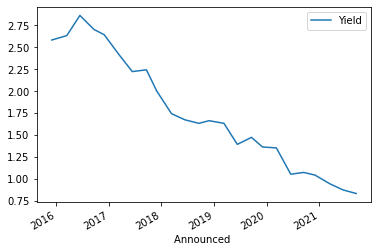

In [46]:
msft_div.plot(x= "Announced ", y= "Yield")
#Should we use the Average Yearly Dividend over the simulated time frame? It seems too high and I feel like it would only ever decrease.
#If the dividend yield is decreasing because the stock price is increasing, then does that mean considering MSFT simulated growth, the yield would decrease even further?


#Suggestion: Run linear regression to progress the dividend yield graph even further. Return the predicted yield into a list and plot it out.

#import numpy as np
# from sklearn.linear_model import LinearRegression



<AxesSubplot:xlabel='Announced '>

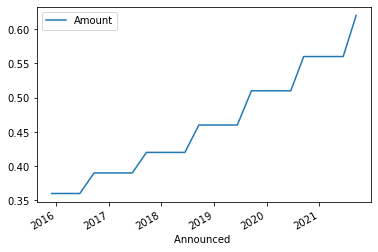

In [47]:
msft_div.plot(x= "Announced ", y= "Amount")

## Okay, so rereading this code, I realized that I diverged a little here, this whole MC with bitcoin is useless and a waste of time but I think the only thing worth keep is the data cleaning of this part so that we can adapt this code to run MC simulation on any stock's dataframe.


<AxesSubplot:xlabel='Date'>

,Date,Open,High,Low,Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0


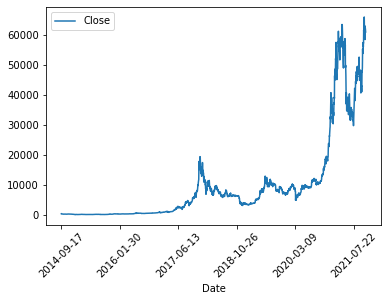

In [49]:
btc_data =pd.read_csv(Path("./Resources/BTC-USD.csv"))
display(btc_data.plot(x="Date", y="Close", rot = 45))
btc_data.drop(columns = "Adj Close", inplace =True)
btc_data.head()

# btc_sma = btc_data["Close"].rolling(window = 60).mean().dropna()
# btc_sma.plot()

,Date,Open,High,Low,Close,Volume,pct_change
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,-0.071926
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,-0.069843
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,0.035735
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,-0.024659
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,0.008352


count    2598.000000
mean        0.002658
std         0.039113
min        -0.371695
25%        -0.012831
50%         0.002032
75%         0.018448
max         0.252472
Name: pct_change, dtype: float64

<AxesSubplot:ylabel='Frequency'>

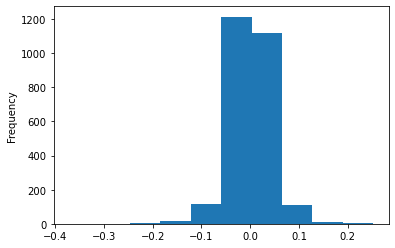

In [50]:
btc_data_pct = btc_data
btc_data_pct["pct_change"] = btc_data["Close"].pct_change()
btc_data_pct.dropna(inplace = True)
display(btc_data_pct.head())

display(btc_data_pct["pct_change"].describe())
btc_data_pct["pct_change"].plot.hist()

#This does not look like a normal distribution so I do not recommend a Monte Carlo Simulation?

### Remember, first time running this cell, uncomment out the `btc_data = pd.concat({'BTC': btc_data}, axis = 1)` line. It adds on an extra index so that the MC simulation works appropiately. Uncomment out after usage. Usually Alpaca returns dataframes with multi-index layers and the MC code was written to accomodate that but if the dataframe came from somewhere else than Alpaca (like this BitCoin csv right here), this line of code could be used to add on an extra index.

In [52]:
btc_data.columns = btc_data.columns.str.lower()
# btc_data = pd.concat({'BTC': btc_data}, axis = 1)
#Comment this out because there already is an additional level

btc_data.head()


BTC                                                              \
         date        open        high         low       close      volume   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0   
5  2014-09-22  399.100006  406.915985  397.130005  402.152008  24127600.0   

              
  pct_change  
1  -0.071926  
2  -0.069843  
3   0.035735  
4  -0.024659  
5   0.008352

In [58]:
MC_ten_year_btc = MCSimulation(portfolio_data = btc_data, 
                      num_simulation= 1000,
                      num_trading_days= 252*10)
MC_ten_year_btc.portfolio_data.head()


BTC                                                              \
         date        open        high         low       close      volume   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0   
5  2014-09-22  399.100006  406.915985  397.130005  402.152008  24127600.0   

                           
  pct_change daily_return  
1  -0.071926          NaN  
2  -0.069843    -0.069843  
3   0.035735     0.035735  
4  -0.024659    -0.024659  
5   0.008352     0.008352

In [59]:
MC_simulated_return = MC_ten_year_btc.calc_cumulative_return()

<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

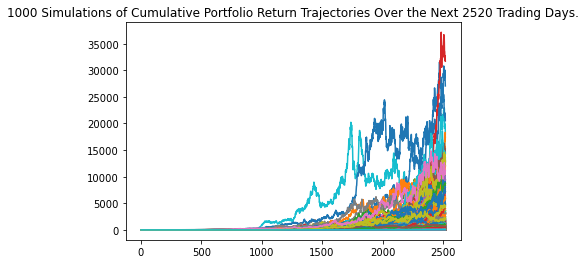

In [29]:
MC_ten_year_btc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

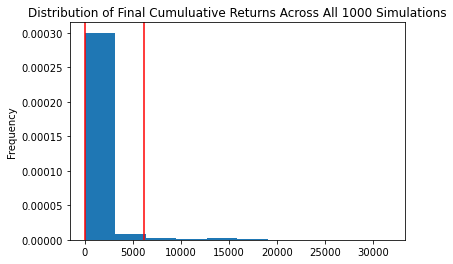

In [33]:
MC_ten_year_btc.plot_distribution()

In [32]:
MC_ten_year_summary_statistics = round(MC_ten_year_btc.summarize_cumulative_return(), 3)
MC_ten_year_summary_statistics

count            1000.000
mean              752.129
std              2350.361
min                 0.347
25%                35.758
50%               111.883
75%               487.523
max             31691.961
95% CI Lower        2.871
95% CI Upper     6170.672
Name: 2520, dtype: float64

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.027094,1.052963,1.056751,0.896137,1.023571,0.950878,1.033804,1.018071,1.021332,0.935363,...,1.086245,0.975323,1.001891,1.020002,1.007687,1.071932,0.957707,0.982351,0.977594,0.987479
2,1.002968,0.992267,1.103348,0.907347,1.024066,0.943012,1.133211,1.132575,1.022322,0.893617,...,1.081391,0.912875,1.018159,1.077351,0.983205,1.035380,0.957292,0.962013,0.949485,0.999466
3,0.979292,0.994599,1.106130,0.944035,0.986449,0.974084,1.104358,1.177322,0.961947,0.940558,...,1.054866,0.965280,1.022824,1.042112,0.956428,1.083953,0.979126,0.992043,0.912803,1.044270
4,1.013256,0.964709,1.126199,0.910831,0.954972,1.009901,1.112106,1.232231,0.974194,0.930621,...,1.053455,0.940655,0.969562,1.102385,0.922080,1.105703,0.948832,0.996824,0.965823,1.065726


<AxesSubplot:title={'center':'Average of 1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days'}, ylabel='Return'>

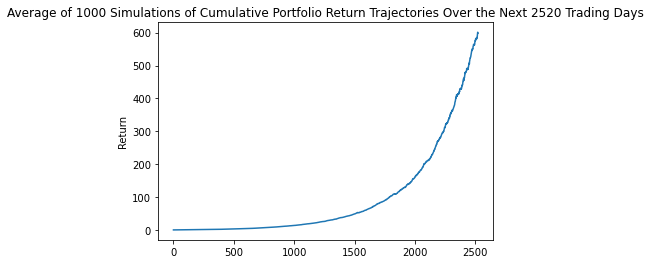

In [46]:
display(MC_simulated_return.head())
MC_single_graph = MC_simulated_return.mean(axis = 1)
MC_single_graph.plot(title  ="Average of 1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days", ylabel = "Return")

## Marks the end of the rambling/unimportant stuff
---------------------------------------------------

Option 2: Take MonteCarlo out each individual year to find the cumulative return to find the approximate pricing of the BTC by the end of the X-th year.

However, what is important is that we take the dividend gained from our stock and continue to compound it into Bitcoin every year. The question is if we use the 95% interval range every year (example. 2.871-6170.672 and use different calculations for both--> create a list of 95% uppers and 95% lowers and spread out from there) to calculate the gains.
or if we use ARIMA (auto regressive integrated moving average) to predict crpyto currency *exclusively* and then use MonteCarlo for the Stock.


For Repeating MC only --> Stock

In [62]:
Upper_Yields = []
Lower_Yields = []
Means = []

currentYear = datetime.datetime.now().year
Years = [currentYear]

msft_shares = 1
multitude_rows = 1000
historic_end = pd.to_datetime("today")
historic_start = historic_end - np.timedelta64(4,"Y")

historic_msft_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = historic_start.isoformat(),
    end = historic_end.isoformat(),
    limit = multitude_rows
).df

historic_msft_data

MSFT                                    
                             open    high       low   close    volume
time                                                                 
2017-11-16 00:00:00-05:00   83.10   83.42   82.9400   83.19  16201819
2017-11-17 00:00:00-05:00   83.12   83.12   82.2400   82.37  17427406
2017-11-20 00:00:00-05:00   82.40   82.59   82.2500   82.54  11458697
2017-11-21 00:00:00-05:00   82.74   83.84   82.7400   83.73  14281714
2017-11-22 00:00:00-05:00   83.83   83.90   83.0400   83.09  12488334
...                           ...     ...       ...     ...       ...
2021-11-01 00:00:00-04:00  331.40  331.49  326.3700  329.38  22920008
2021-11-02 00:00:00-04:00  330.21  333.45  330.0000  333.26  21366225
2021-11-03 00:00:00-04:00  334.15  334.90  330.6500  333.98  16800906
2021-11-04 00:00:00-04:00  333.07  336.54  329.5100  336.46  19740179
2021-11-05 00:00:00-04:00  338.60  338.86  334.4217  336.11  18428508

[1000 rows x 5 columns]

In [ ]:
#for x in range(number of years)

for x in range(10):
    MC_looped_msft = MCSimulation(portfolio_data = historic_msft_data, 
                      num_simulation= 500,
                      num_trading_days= 252*x+1)
    MC_summary_stats = MC_looped_msft.summarize_cumulative_return()
    Upper_Yields.append(MC_summary_stats["95% CI Upper"])
    Lower_Yields.append(MC_summary_stats["95% CI Lower"])
    Means.append(MC_summary_stats["mean"])
    Years.append(currentYear+(x+1))

In [65]:
display(Lower_Yields)
display(Upper_Yields)
display(Means)

[0.9664053498340239,
 0.8011363486614549,
 0.9309003750092444,
 1.025605404146758,
 1.2001197284441374,
 1.71178793029266,
 2.0494145255971117,
 2.520037828048811,
 3.0965992475766573,
 4.206943450504849]

[1.0362741061436076,
 2.5018302931556775,
 4.699843596938447,
 7.200022887095695,
 14.039327985252049,
 22.472508499719414,
 35.522155793865394,
 52.258904154792646,
 80.77386557954685,
 124.9346283012018]

[1.0019829271143361,
 1.4930669645006127,
 2.1912882180209756,
 3.1563082912289198,
 5.0687717744243255,
 7.531930955722895,
 10.948816302160672,
 16.8270627006582,
 22.754614614134486,
 33.18624057499681]

In [1]:
potential_upper_price = [element * historic_msft_data["MSFT"]["close"][-1] for element in Upper_Yields]
potential_lower_price = [element * historic_msft_data["MSFT"]["close"][-1] for element in Lower_Yields]
potential_mean_price = [element * historic_msft_data["MSFT"]["close"][-1] for element in Means]
#for ticks, enter the number of years you are simulating
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10], labels = Years, rot = 45)
plt.plot(potential_lower_price)
plt.plot(potential_upper_price)
plt.plot(potential_mean_price)



NameError: name 'Upper_Yields' is not defined